In [ ]:
!pip install tensorflow==2.16.2
!pip install --upgrade boto3

**IMPORTS**

In [64]:
import tensorflow as tf
# Changes AWS to True if on SageMaker Instance and set S3 BUCKET and Key accordingly
AWS = False
REGION = 'eu-west-1'
BUCKET = 'ml-can-ids-logs'
s3 = None

# Import Functions
import setuptools.dist

from importlib import reload
import utils
import anomaly_detection_functions
import feature_selection
import train
import id_embedding

reload(utils)
reload(train)
reload(anomaly_detection_functions)
reload(feature_selection)
reload(id_embedding)

from utils import plot_loss_curve, plot_pca, plot_tsne, get_confusion_matrix, get_latent_representations_label, analyze_latent_variance, analyze_kl_divergence, linear_annealing, save_results_to_excel, save_trained_model, get_s3_client, check_dataset
from anomaly_detection_functions import get_threshold_from_train, anomaly_detection, get_anomaly_detection_accuracy, prepare_features, train_isolation_forest, train_one_class_svm, detect_anomalies_isolation_forest, detect_anomalies_one_class_svm
from anomaly_detection_functions import visualize_anomalies, evaluate_anomaly_detector, get_mean_variances, detect_anomalies_one_class_svm_with_threshold, train_hdbscan_detector, evaluate_hdbscan_detector, detect_anomalies_hdbscan, hdbscan_set_threshold, visualize_results
from feature_selection import feature_selection_preparation, convert_to_tensorflow
from train import train_model, train_model_factor , train_model_btc, train_model_bernoulli
from id_embedding import train_embedding

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, Model
import itertools
import pandas as pd
from datetime import datetime
import warnings
import keras
from scipy.stats import entropy
import scipy.stats
from tensorflow.keras.optimizers.schedules import CosineDecay
from importlib import reload
import gc
import tensorflow.keras.backend as K

if AWS:
    import boto3
    from io import StringIO

# Adjust pandas display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # No wrapping, long rows won't be cut off
pd.set_option('display.max_colwidth', None)  # Show full column content (especially useful for long strings)

# Remove this after testing/debugging
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("✅ Using GPU")
    device = "/GPU:0"
else:
    print("❌ Using CPU")
    device = "/CPU:0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs")
    except RuntimeError as e:
        print(e)

Num GPUs Available: 0
❌ Using CPU


------------------------------------------------------------------

**PATH FILES**

In [2]:
if AWS:
    s3 = get_s3_client(REGION, BUCKET, True)
    
    # Get S3 Object 
    channel2logs = s3.get_object(Bucket = BUCKET, Key= 'channel2Logs.csv')
    dos_attack_channel2 = s3.get_object(Bucket = BUCKET, Key= 'dos_attack_channel2.csv')
    replay_attack_channel2 = s3.get_object(Bucket = BUCKET, Key = 'replay_attack_channel2.csv') 
    spoofing_attack_channel2 = s3.get_object(Bucket = BUCKET, Key = 'new_spoofing_attack_channel2.csv') 

    channel2logs = channel2logs['Body'].read().decode('utf-8')
    dos_attack_channel2 = dos_attack_channel2['Body'].read().decode('utf-8')
    replay_attack_channel2 = replay_attack_channel2['Body'].read().decode('utf-8')
    spoofing_attack_channel2 = spoofing_attack_channel2['Body'].read().decode('utf-8')

    # Get Content
    channel2logs = StringIO(channel2logs)
    dos_attack_channel2 = StringIO(dos_attack_channel2)
    replay_attack_channel2 = StringIO(replay_attack_channel2)
    spoofing_attack_channel2 = StringIO(spoofing_attack_channel2)

    # Attack based on Channel
    preprocessed_DoS_channel2_csv_path = dos_attack_channel2 # DoS on channel 2 (Red Channel)
    preprocessed_Replay_channel2_csv_path = replay_attack_channel2 # Replay on channel 2 (Red Channel)
    preprocessed_Spoofing_channel2_csv_path = spoofing_attack_channel2 # Spoofing on channel 2 (Red Channel)

    # Unprocessed Channel Data
    preprocessed_normal_channel2_csv_path = channel2logs # Red Channel
    preprocessed_normal_channel4_csv_path = "" # Yellow Channel
    preprocessed_normal_channel5_csv_path = "" # Green Channel

    # Current best model
    best_model_path = ""
else:
    # Unprocessed Normal and Attack Data
    preprocessed_normal_csv_path = './Dataset/Tw22206_L003_with_ecu_channel.csv'  # Normal Unprocessed
    preprocessed_DoS_csv_path = './Dataset/Attack_Logs/dos_attack.csv'  # Dos Unprocessed
    preprocessed_Fuzzy_csv_path = './Dataset/Attack_Logs/fuzzy_attack.csv'  # Fuzzy Unprocessed
    preprocessed_Replay_csv_path = './Dataset/Attack_Logs/replay_attack.csv'  # Replay Unprocessed - Test
    preprocessed_Spoofing_csv_path = './Dataset/Attack_Logs/spoofing_attack.csv'  # Spoofing Unprocessed
    preprocessed_Suspension_csv_path = './Dataset/Attack_Logs/suspension_attack.csv'  # Suspension Unprocessed - Hardest Attack Type


    # Attack based on Channel
    preprocessed_DoS_channel2_csv_path = './Dataset/Attack_Logs/dos_attack_channel2.csv'  # DoS on channel 2 (Red Channel)
    preprocessed_Replay_channel2_csv_path = './Dataset/Attack_Logs/replay_attack_channel2.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_new_Replay_channel2_csv_path = './Dataset/Attack_Logs/new_replay_attack_channel2.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_Suspension_channel2_csv_path = './Dataset/Attack_Logs/suspension_attack_channel2.csv'  # Suspension on channel 2 (Red Channel)
    preprocessed_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/spoofing_attack_channel2.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_new_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/new_spoofing_attack_channel2.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_parkingBrake_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/ParkingBrakeController_EPB__spoofing_attack_channel2.csv'  # Spoofing on channel 2 (Red Channel)

    # Unprocessed Channel Data
    preprocessed_normal_channel0_csv_path = './Dataset/Channel_Logs/channel0Logs.csv'
    preprocessed_normal_channel2_csv_path = './Dataset/Channel_Logs/channel2Logs.csv'  # Red Channel
    preprocessed_normal_channel4_csv_path = './Dataset/Channel_Logs/channel4Logs.csv'  # Yellow Channel
    preprocessed_normal_channel5_csv_path = './Dataset/Channel_Logs/channel5Logs.csv'  # Green Channel


    # Preprocessed Dataframe Data
    processeddataframe_normal_csv_path = './Dataset/Processed_Dataframes/train_dataframe.csv'  # Normal CSV Dataframe (Turns Lists into Strings)
    processeddataframe_DoS_csv_path = './Dataset/Processed_Dataframes/test_DoS_dataframe.csv'  # DoS CSV Dataframe (Turns Lists into Strings)

    # Preprocessed Pickle Data
    processeddataframe_normal_pickle_path = './Dataset/Processed_Dataframes/train_Normal_dataframePickle.pkl'  # Normal Pickle Dataframe
    processeddataframe_DoS_pickle_path = './Dataset/Processed_Dataframes/test_DoS_dataframePickle.pkl'  # DoS Pickle Dataframe

    # Current best model
    best_model_path = "./Resources/Models/SOA_VAE_E6_LD38_EP30_NT100000_B1024_I42.keras"



    # PRELOAD Dataframe for Debug
    DEBUG = False 


---------------------------------------------

In [48]:
reload(utils)
reload(feature_selection)
LOAD_DATAFRAME = False
BINARY = False
BINARY_ID = False

n_rows_train = 80000   # select how many rows to load. None if whole train datasset
n_rows_test = 50000   # select how many rows to load. None if whole test datasset
batch_size = 1024
window_size = 50    # increase window size
stride = 20     # increase stride as a buffer
split_ratio = 0.8     # % of training data to use for training
window_anomaly = 9  # For 1 anomaly per window do: 1 / window_size
if LOAD_DATAFRAME:
    # Load training data
    processeddataframe = pd.read_pickle(processeddataframe_normal_pickle_path)
    train_dataset = convert_to_tensorflow(processeddataframe['features'], batch_size= batch_size)

    # Load test data
    processeddataframe_test = pd.read_pickle(processeddataframe_DoS_pickle_path)
    test_dataset = convert_to_tensorflow(processeddataframe_test['features'] ,processeddataframe_test['type'], batch_size= batch_size )
else:
    # Preprocess and load training data
    processeddataframe , embedding_model, id_to_embedding = feature_selection_preparation(preprocessed_normal_channel2_csv_path, phase = 'training', rows=n_rows_train, binary = BINARY, binary_id= BINARY_ID)
    train_dataset, val_dataset = convert_to_tensorflow(processeddataframe['features'], batch_size= batch_size, window_size = window_size, stride = stride, split_ratio= split_ratio)

    processeddataframe_test = feature_selection_preparation(preprocessed_DoS_channel2_csv_path, phase = 'test', rows=n_rows_test, binary = BINARY, binary_id = BINARY_ID, embedding_model = embedding_model, id_to_embedding = id_to_embedding)
    test_dataset, test_threshold_dataset = convert_to_tensorflow(processeddataframe_test['features'], processeddataframe_test['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly = window_anomaly)

    #processeddataframe_dos_baseline = feature_selection_preparation(preprocessed_DoS_channel2_csv_path, 'test', rows=n_rows_test)
    #dos_test_dataset, dos_threshold_dataset = convert_to_tensorflow(processeddataframe_dos_baseline['features'], processeddataframe_dos_baseline['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly_ratio = window_anomaly_ratio)

#############START#####################
Amount of unique IDS in training: 96
---Training Embedding Network for Arbitration IDs---
Epoch [0/100], Loss: 0.9712
Epoch [10/100], Loss: 0.3957
Epoch [20/100], Loss: 0.1190
Epoch [30/100], Loss: 0.0357
Epoch [40/100], Loss: 0.0091
Epoch [50/100], Loss: 0.0038
Epoch [60/100], Loss: 0.0009
Epoch [70/100], Loss: 0.0005
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0001
-- ------------------ ---
Average time for ID calculations: 0.000176 seconds
Average time for payload AVERAGE calculations: 0.000073 seconds
Average time for payload CHANGE calculations: 0.000045 seconds
Average time for Entropy per ID calculations: 0.000048 seconds
Compute Temporal Features completed 27.51 seconds
Feature Selection completed in 51.78 seconds
Sliding completed (train) in 0.0160630 seconds
-----------------------------------
Original window that works:  (3998, 50, 24)
Feature shape BEFORE sliding window: (80000, 24)
Feature shape AFTER sliding window: (3998, 

**SAVE Dataset to npz [FIX]**

In [131]:
path=r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Processed_Dataframes/Channel2_Full_43Features_WindowFeatures_1024Batch_50Window_5Stride.npz"

# Save your datasets
save_datasets(train_dataset, val_dataset, path)

# Later, load them back
train_dataset_loaded, val_dataset_loaded = load_datasets(path)

NameError: name 'save_datasets' is not defined

In [281]:
# todo: check that all values normalized or there's nans in the sliding windows
# todo: check whole processing of df
print(processeddataframe['data'].head(1))
print(processeddataframe_test['features'].head(40))
print(np.size(processeddataframe['features'][0]))

processeddataframe['has_nan'] = processeddataframe['features'].apply(lambda x: any(pd.isna(x)) if isinstance(x, list) else np.nan)
valid_lists = [lst for lst in processeddataframe['features'] if isinstance(lst, list)]
all_values = sum(valid_lists, [])
has_nan = any(pd.isna(all_values))
has_out_of_bounds = any(x < 0 or x > 1 for x in all_values if isinstance(x, (int, float)))

print(f"Contains NaN: {has_nan}")
print(f"Contains values <0 or >1: {has_out_of_bounds}")

# Run checks for both datasets
check_dataset(train_dataset, "Train Dataset")
check_dataset(val_dataset, "Validation Dataset")

0    fc ff ff ff 03 ff ff ff
Name: data, dtype: object
0                                     [0.6684948801994324, 1.3079891204833984, -0.8744547963142395, -1.1350228786468506, 0.9937095642089844, 0.4648195505142212, 0.5307573676109314, -0.16732318699359894, -1.1470959186553955, -0.33683449029922485, 1.1264023046009437, 1.3965398249064147, 1.2393093689640502, 1.0586209665557336, -1.5444939390527477, 0.9261811234723625, 0.872329017309939, 1.1124198289005782, 0.023809523809523808, -2.7756914680695206, -1.1873788834502175, 0.3333333333333333, 0.0, 0.0]
1                            [-1.3114874362945557, -1.0665690898895264, -0.04894024878740311, -0.40186017751693726, -0.10313114523887634, -0.08246015012264252, -0.9506476521492004, 0.8059439063072205, -0.1452120989561081, -0.054634902626276016, -1.5199952841082147, 1.2710050897594967, -1.2369601081472168, 1.0586209665557336, -0.9464049829041371, 0.9261811234723625, 0.872329017309939, 0.6735143523856225, 0.023809523809523808, -2.7756647425282

-----------------------------------------------------------

**VAE SETUP**

In [4]:
@keras.saving.register_keras_serializable(package="VAE_Mean_Variance_Decoder")
class VAE_Mean_Variance_Decoder(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_Mean_Variance_Decoder, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences=True), 
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(128, activation = 'relu', return_sequences = True), 
            #layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
            #layers.TimeDistributed(layers.Dense(input_dim))  # Output must match (window_size, input_dim)
        ])
        # Split into mean and logvar outputs
        self.decoder_mean = layers.TimeDistributed(layers.Dense(input_dim))
        self.decoder_logvar = layers.TimeDistributed(layers.Dense(input_dim))


    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        #print("Z Shape at Decode: " , z.shape)

        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        #print("Z_FLAT Shape at Decode: " , z.shape)
        reconstructed_flat = self.decoder(z_flat)
        # Get mean and logvar
        mean_flat = self.decoder_mean(reconstructed_flat)
        logvar_flat = self.decoder_logvar(reconstructed_flat)
    
        # Reshape back to include samples dimension
        mean = tf.reshape(mean_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))
        logvar = tf.reshape(logvar_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))
        
        return mean, logvar

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed_mean, reconstructed_logvar = self.decode(z)

        #print("Reconstructed Mean: " , reconstructed_mean.shape)
        #print("Reconstructed Logvar: " , reconstructed_logvar.shape)


        return reconstructed_mean, reconstructed_logvar, mu, logvar
    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_Mean_Variance_Decoder, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [5]:
@keras.saving.register_keras_serializable(package="VAE_multiplesamples")
class VAE_multiplesamples(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_multiplesamples, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences=True), 
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(128, activation = 'relu', return_sequences = True), 
            #layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
            layers.TimeDistributed(layers.Dense(input_dim))  # Output must match (window_size, input_dim)
        ])
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        """
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        """
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.
        """
        #print("Z shape: ", z.shape)
        #print("z_mean shape: ", z_mean.shape)
        #print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        #print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        #print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_multiplesamples, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [6]:
@keras.saving.register_keras_serializable(package="VAE_weak_generator")
class VAE_weakGenerator(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_weakGenerator, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(200, activation='relu', return_sequences= True),
            layers.LSTM(200, activation='relu', return_sequences= True),
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(200, activation='relu', return_sequences= True),
            layers.LSTM(200, activation='relu', return_sequences= True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        """
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        """
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.
        """
        #print("Z shape: ", z.shape)
        #print("z_mean shape: ", z_mean.shape)
        #print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        #print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        #print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_weakGenerator, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [7]:
@keras.saving.register_keras_serializable(package="VAE_2x")
class VAE_2x(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_2x, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(200, activation='relu', return_sequences=True), 
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(10, activation = 'relu', return_sequences = True), 
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        """
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        """
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.
        """
        #print("Z shape: ", z.shape)
        #print("z_mean shape: ", z_mean.shape)
        #print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        #print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        #print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_2x, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [8]:
@keras.saving.register_keras_serializable(package="VAE_2x_weak_generator")
class VAE_2x_weak_generator(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_2x_weak_generator, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(200, activation='relu', return_sequences=True), 
            #layers.BatchNormalization(), # Experiment: BN
            layers.LSTM(180, activation='relu', return_sequences= True),
            layers.LSTM(80, activation='relu', return_sequences= True), # return sequence?
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(80, activation = 'relu', return_sequences = True), 
            layers.LSTM(180, activation='relu', return_sequences=True),
            #layers.BatchNormalization(),
            layers.LSTM(200, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        """
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        """
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:
    "Disentangling by Factorising"
    (https://arxiv.org/abs/1802.05983)

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.

        from: ..
        """
        #print("Z shape: ", z.shape)
        #print("z_mean shape: ", z_mean.shape)
        #print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        #print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        #print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_2x_weak_generator, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

**Bernoulli VAE**

In [261]:
@keras.saving.register_keras_serializable(package="Bernoulli_VAE")
class Bernoulli_VAE(Model):
    def __init__(self, input_dim, latent_dim, window_size,  bernoulli_prior_p=0.5 ,**kwargs):
        super(Bernoulli_VAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  
        self.bernoulli_prior_p = bernoulli_prior_p

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences=True), 
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = tf.keras.Sequential([
            layers.Dense(latent_dim),
            layers.Activation('softplus')
        ])

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(128, activation = 'relu', return_sequences = True), 
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
       
    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        eps = tf.random.normal(shape=(tf.shape(mu)[0], tf.shape(mu)[1]))
        std = tf.sqrt(logvar)  # More stable alternative to exp UNSTABLE FIX
        #print(std)
        #print("mu shape at reparm: ", mu.shape)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)

    def decode(self, z):
        #print("z shape at deocde ", z.shape)
        reconstructed = self.decoder(z)
        #print("Reconstructed X at deocde ", reconstructed.shape)
        return reconstructed

    def call(self, x, n_samples = 1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        #print("Reconstructed X after decode and reshape ", reconstructed.shape)

        return reconstructed, mu, logvar, z
    
    def bernoulli_prior_logpdf(self, z):
        """Calculate log probability of z under a Bernoulli prior
        
        For continuous latent variables, we use a "relaxed" Bernoulli prior:
        p(z) ~ Bernoulli(p) where z is "pushed" toward 0 or 1
        """
        # Compute the log probability of z under a Bernoulli-like prior
        # p(z) ~ Bernoulli(p) where p is self.bernoulli_prior_p
        # For each dimension, we compute the probability based on how close z is to 0 or 1
        
        # Component that favors values close to 0
        log_prob_0 = tf.math.log(1 - self.bernoulli_prior_p + 1e-10) - tf.square(z) / 0.1
        
        # Component that favors values close to 1
        log_prob_1 = tf.math.log(self.bernoulli_prior_p + 1e-10) - tf.square(z - 1) / 0.1
        
        # Combine (use log-sum-exp trick for numerical stability)
        max_val = tf.maximum(log_prob_0, log_prob_1)
        log_prob = max_val + tf.math.log(
            tf.exp(log_prob_0 - max_val) + tf.exp(log_prob_1 - max_val)
        )
        
        return log_prob
    #####################################################################################

    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(Bernoulli_VAE, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size,  # Window size
            "bernoulli_prior_p" : self.bernoulli_prior_p
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'], bernoulli_prior_p = config['bernoulli_prior_p'])

**VQ-VAE**

**SEMI SUPERVISED: LR-SEMI**

In [9]:
import tensorflow_probability as tfp

tfd = tfp.distributions
"""
LR-SEMI is based on the paper:

"Semisupervised anomaly detection of multivariate time series based on a variational autoencoder"
(https://doi.org/10.1007/s10489-022-03829-1)

Since we only use labeled data we are omitting the unlabeled loss shown in equation 2
"""
@keras.saving.register_keras_serializable(package="LR_SEMIVAE")
class LR_SEMIVAE(Model):
    def __init__(self, input_dim, latent_dim, window_size,num_classes, lambda_cls, **kwargs):
        super(LR_SEMIVAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  
        self.num_classes = num_classes
        self.lambda_cls = lambda_cls 

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences=True), 
            layers.GlobalAveragePooling1D()

        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim + 1,)), # + 1 for the z + label concat
            layers.RepeatVector(window_size),  
            layers.LSTM(128, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])

        self.LR_classifier = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='tanh'),  # Linear → Tanh
            tf.keras.layers.Dense(64, activation='tanh'),   # Linear → Tanh
            tf.keras.layers.Dense(32),                      # Linear (no activation)
            tf.keras.layers.Dense(input_dim, activation='sigmoid')  # Final softmax layer? wrong
        ])

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
    

    def decode(self, z, y = None):
        return 

    def call(self, inputs, n_samples=1, training = None):
        return
    def compute_loss(self, x , y, model_outputs, n_samples = 1):
        return

    def get_config(self):
        config = super(LR_SEMIVAE, self).get_config()
        config.update({
            'input_dim': self.input_dim,
            'latent_dim': self.latent_dim,
            'window_size': self.window_size,
            'num_classes': self.num_classes,
            'lambda_cls': self.lambda_cls
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

KeyboardInterrupt: 

--------------------------------------

In [ ]:
# Not Done

# Model parameters
input_dim = np.size(processeddataframe['features'][0])
latent_dim = 32
num_classes = 2
lambda_cls = 1.0

test_dataset = test_dataset.map(lambda x, y: (x, y))  # No need for one-hot encoding

# Check the shape of the dataset
for batch, label in test_dataset.take(1):  # Or val_dataset if testing
    print("Batch shape: ", batch.shape)  # Print the shape of the input data
    print("Label shape: ", label.shape)  # Print the shape of the labels

# Create the model
model = LR_SEMIVAE(
    input_dim=input_dim,
    latent_dim=latent_dim,
    window_size=window_size,
    num_classes=num_classes,
    lambda_cls=lambda_cls
)
optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4)
# Compile the model
model.compile(
    optimizer = optimizer,
    metrics=['accuracy']
)

import tensorflow as tf

def train_model(model, optimizer, epochs, batch_size, train_dataset):
    # Initialize variables for tracking losses and epochs
    epoch_loss = 0
    real_epochs = 0

    # Training loop
    for epoch in range(epochs):
        real_epochs += 1
        epoch_loss = 0
        
        # Loop through each batch in the training dataset
        for x, y in test_dataset:  # Loop through batches

            with tf.GradientTape() as tape:
                model_outputs = model([x,y], n_samples=1, training=True)
                # Compute loss
                loss_dict = model.compute_loss(x, y, model_outputs)
                total_loss = loss_dict['total_loss']

            # Compute gradients and apply them
            gradients = tape.gradient(total_loss, model.trainable_variables)  # Replace `model.trainable_variables`
            gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))  # Replace `model.trainable_variables`

            epoch_loss += total_loss.numpy()  # Accumulate loss

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_dataset)}")

train_model(model, optimizer,5,batch_size, test_dataset)


**TRAINING**

steps:  400
Input Dimension = 24, Latent Dimension = 30, Beta = 50, Validation Method = B_VAE, Rows in Training Data = 80000, Batch Size = 1024 
Epoch 1, Train Loss: 19.531857, Val Loss: 9.817190
Epoch 2, Train Loss: 3.885505, Val Loss: 3.172638
Epoch 3, Train Loss: 2.673021, Val Loss: 1.876382
Epoch 4, Train Loss: 2.231220, Val Loss: 1.771631
Epoch 5, Train Loss: 1.708959, Val Loss: 1.567523
Epoch 6, Train Loss: 1.344521, Val Loss: 1.435438
Epoch 7, Train Loss: 1.197193, Val Loss: 1.272883
Epoch 8, Train Loss: 1.102356, Val Loss: 1.120803
Epoch 9, Train Loss: 1.060639, Val Loss: 1.073990
Epoch 10, Train Loss: 1.033873, Val Loss: 1.056069
Epoch 11, Train Loss: 1.007480, Val Loss: 1.043834
Epoch 12, Train Loss: 0.995638, Val Loss: 1.026214
Epoch 13, Train Loss: 0.987200, Val Loss: 1.019815
Epoch 14, Train Loss: 0.989790, Val Loss: 1.014194
Epoch 15, Train Loss: 0.977287, Val Loss: 1.009055
Epoch 16, Train Loss: 0.971526, Val Loss: 1.003830
Epoch 17, Train Loss: 0.967922, Val Loss: 1.005

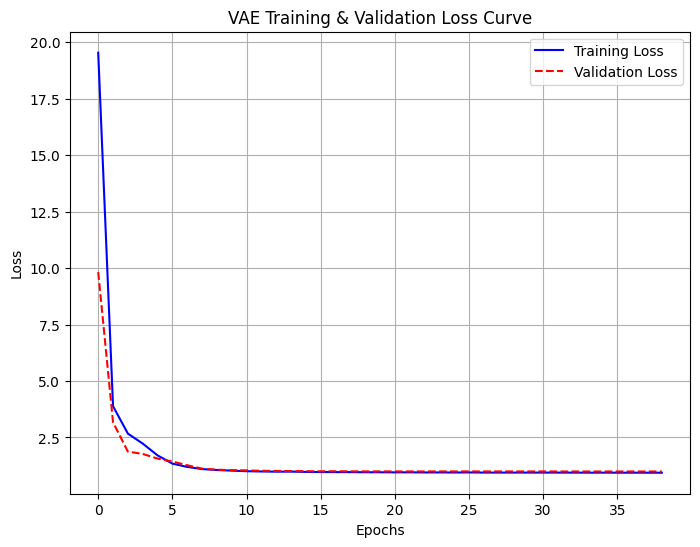

c:\Users\SCHUGD\Desktop\MasterThesis\github_USE_THIS!!\MasterThesis\utils.py:225: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


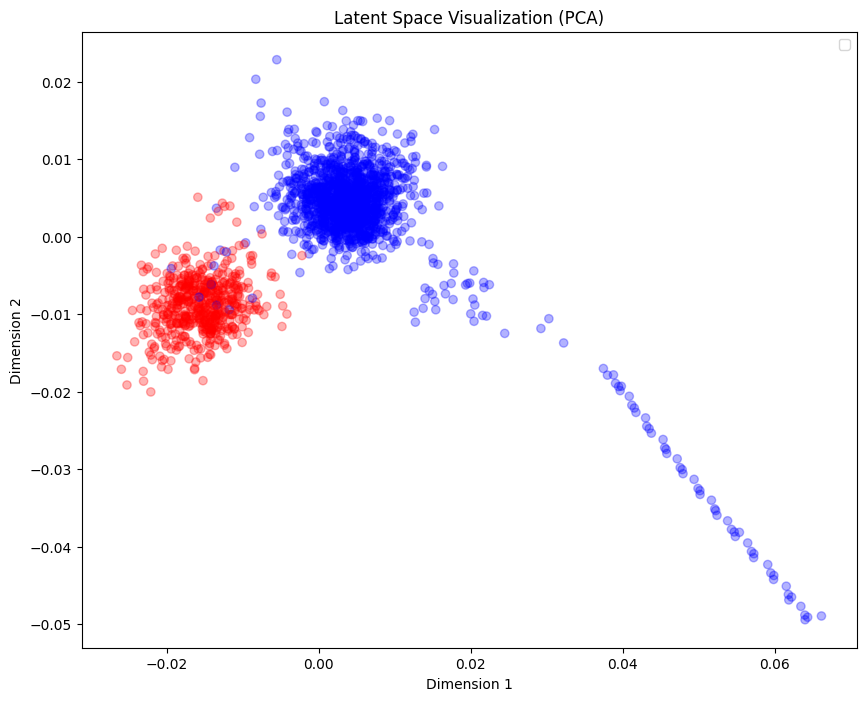

c:\Users\SCHUGD\Desktop\MasterThesis\github_USE_THIS!!\MasterThesis\utils.py:225: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


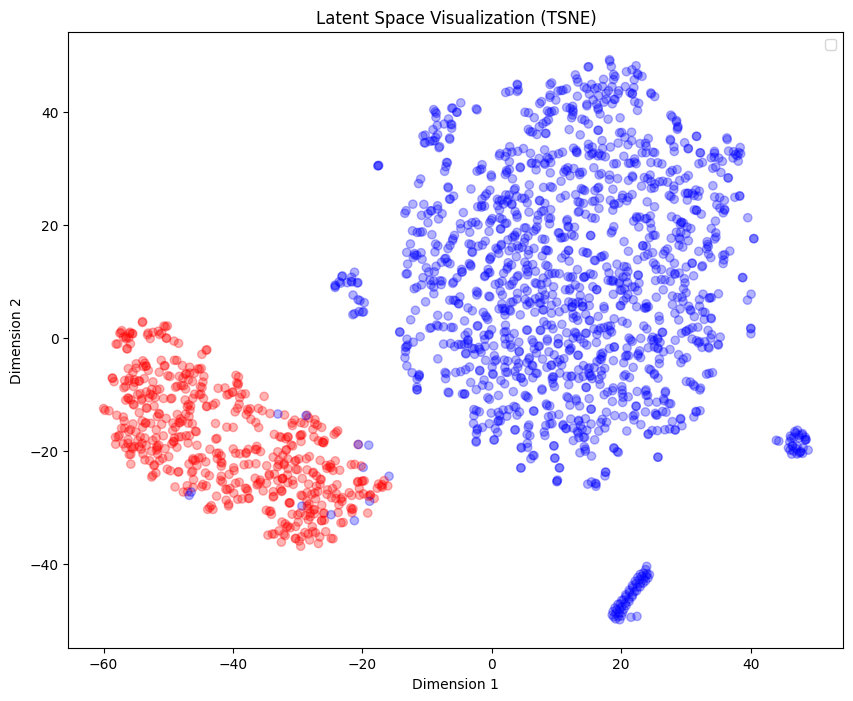

NameError: name 'alse' is not defined

In [9]:
reload(utils)
reload(train)
reload(anomaly_detection_functions)
# Regular HYPERPARAMETERS 
input_dim = np.size(processeddataframe['features'][0])
epochs = 100
n_samples = 10
learning_rate = 1e-04
weight_decay = 1e-06
learning_rate_disc = 5e-5 # FactorVAE

steps_anneal = epochs * len(train_dataset)  
print("steps: ", steps_anneal) 
alpha = 0.0  # Minimum learning rate as a fraction of the initial learning rate
validation_method = "B_VAE" # None, B_VAE, TC, B_TCVAE, PLOT
patience = 5  

# IMPORTANT 
latent_dim= 30
beta = 50 # 50
beta_tc = 1.008 #1.008 # keep in mind this is tuned based on that we get tc loss = -244..
gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0
##################

AD = True

time = datetime.now().strftime("%H-%M")
model_name ="LSTM_VAE"
#model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'

cosine_decay_schedule = CosineDecay(
    1e-03, steps_anneal, alpha=alpha
)


#vae = Bernoulli_VAE(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size, bernoulli_prior_p= 0.5)
#vae = VAE_Mean_Variance_Decoder(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
vae = VAE_multiplesamples(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)

#optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay, beta_1=beta1, beta_2=beta2)
optimizer = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)

train_losses, val_losses, real_epochs, time, show_val, model_path, vae = train_model(vae,optimizer,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= "", train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)


plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
get_latent_representations_label(vae, test_dataset,latent_dim, beta,n_critic,gamma,time, 'PCA', save = False)
get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs, name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)

if AD:
  reconstruction_AD = True
  latent_AD = False
  reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD)
  results, results_probs, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
  reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)

**HyperParamter Search**

Training with: latent_dim=60, beta=30 validation_method=PLOT
VAE--------------
Latent Dimension = 60, Beta = 30, Validation Method = PLOT, Rows in Training Data = 200000, Batch Size = 1024
Epoch 1, Train Loss: 27.843790, Val Loss: 0.000000
Epoch 2, Train Loss: 4.159608, Val Loss: 0.000000
Epoch 3, Train Loss: 1.485557, Val Loss: 0.000000
Epoch 4, Train Loss: 0.965968, Val Loss: 0.000000
Epoch 5, Train Loss: 0.843678, Val Loss: 0.000000
Epoch 6, Train Loss: 0.764892, Val Loss: 0.000000
Epoch 7, Train Loss: 0.715106, Val Loss: 0.000000
Epoch 8, Train Loss: 0.685150, Val Loss: 0.000000
Epoch 9, Train Loss: 0.669656, Val Loss: 0.000000
Epoch 10, Train Loss: 0.659361, Val Loss: 0.000000
Epoch 11, Train Loss: 0.651506, Val Loss: 0.000000
Epoch 12, Train Loss: 0.646720, Val Loss: 0.000000
Epoch 13, Train Loss: 0.643548, Val Loss: 0.000000
Epoch 14, Train Loss: 0.641352, Val Loss: 0.000000
Epoch 15, Train Loss: 0.639538, Val Loss: 0.000000
Epoch 16, Train Loss: 0.638223, Val Loss: 0.000000
Epo

c:\Users\SCHUGD\Desktop\MasterThesis\github_USE_THIS!!\MasterThesis\utils.py:225: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


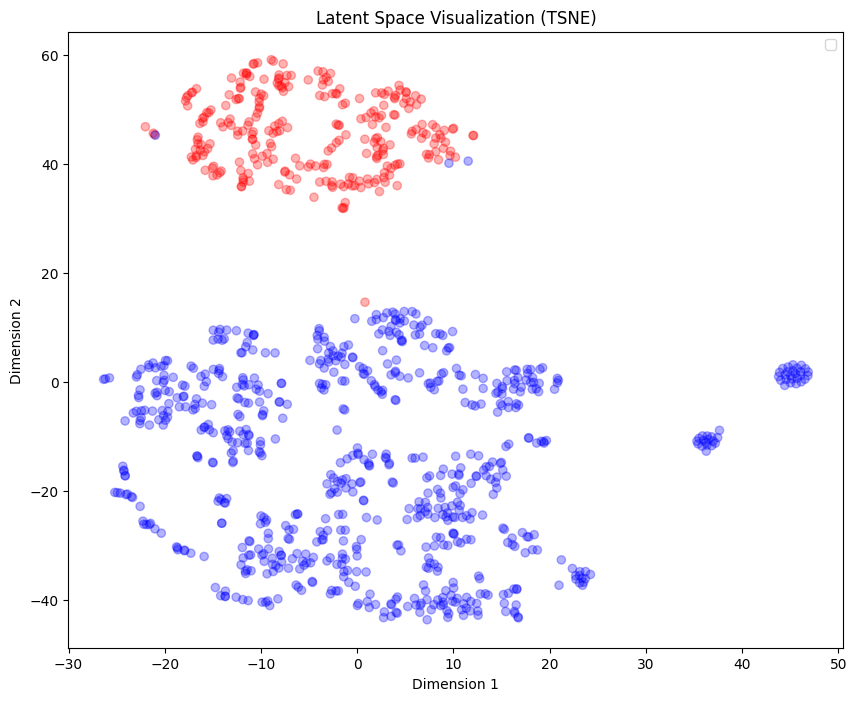

Epoch 51, Train Loss: 0.629500, Val Loss: 0.000000
💽Saved Model at Epoch 51💽
Epoch 52, Train Loss: 0.629451, Val Loss: 0.000000
Epoch 53, Train Loss: 0.629394, Val Loss: 0.000000
Epoch 54, Train Loss: 0.629341, Val Loss: 0.000000
Epoch 55, Train Loss: 0.629304, Val Loss: 0.000000
Epoch 56, Train Loss: 0.629255, Val Loss: 0.000000
Epoch 57, Train Loss: 0.629205, Val Loss: 0.000000
Epoch 58, Train Loss: 0.629170, Val Loss: 0.000000
Epoch 59, Train Loss: 0.629131, Val Loss: 0.000000
Epoch 60, Train Loss: 0.629098, Val Loss: 0.000000
Epoch 61, Train Loss: 0.629062, Val Loss: 0.000000
Epoch 62, Train Loss: 0.629028, Val Loss: 0.000000
Epoch 63, Train Loss: 0.628999, Val Loss: 0.000000
Epoch 64, Train Loss: 0.628968, Val Loss: 0.000000
Epoch 65, Train Loss: 0.628938, Val Loss: 0.000000
Epoch 66, Train Loss: 0.628915, Val Loss: 0.000000
Epoch 67, Train Loss: 0.628880, Val Loss: 0.000000
Epoch 68, Train Loss: 0.628862, Val Loss: 0.000000
Epoch 69, Train Loss: 0.628838, Val Loss: 0.000000
Epoch

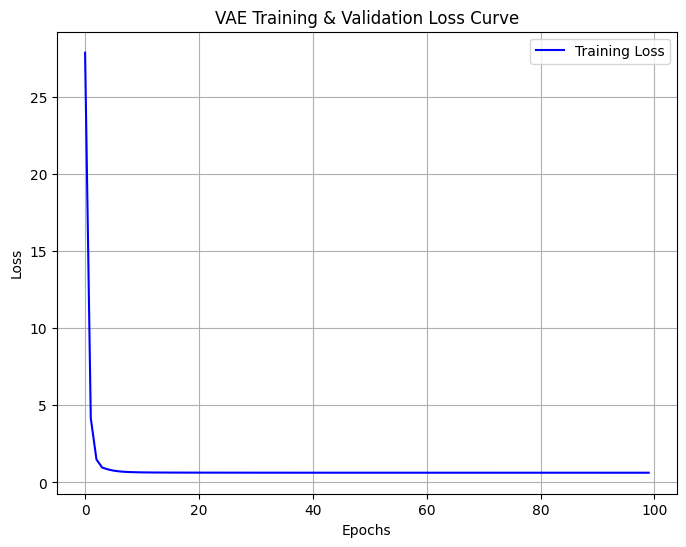

c:\Users\SCHUGD\Desktop\MasterThesis\github_USE_THIS!!\MasterThesis\utils.py:225: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


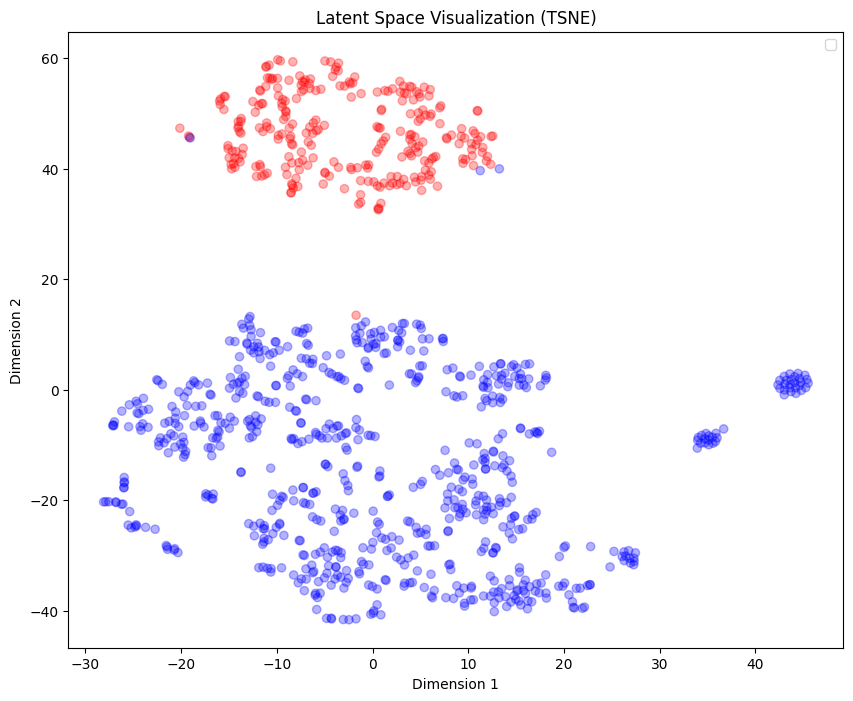

Reconstructed shape:  (10, 1000, 50, 43)
Reconstructed shape:  (1000, 50, 43)
Batch shape:  (1000, 50, 43)
BINARY log_probs shape:  (1000, 50, 29)
CONTINOUS log_probs shape:  (1000, 50, 14)
log_probs shape:  (1000, 50, 43)
mean final reconstruction score shape:  (1000,)
recon error from val 0.626446545124054
recon error from val 0.6224064826965332
recon error from val 0.6115768551826477
recon error from val 0.6226820945739746
recon error from val 0.6428473591804504
recon error from val 0.616100013256073
recon error from val 0.6121379137039185
recon error from val 0.6269540190696716
recon error from val 0.6331605315208435
recon error from val 0.607165515422821
recon error from val 0.6491953730583191
recon error from val 0.6518682837486267
recon error from val 0.6115520000457764
recon error from val 0.6232796311378479
recon error from val 0.6221520900726318
recon error from val 0.6163685321807861
recon error from val 0.6112621426582336
recon error from val 0.6519672870635986
recon error 

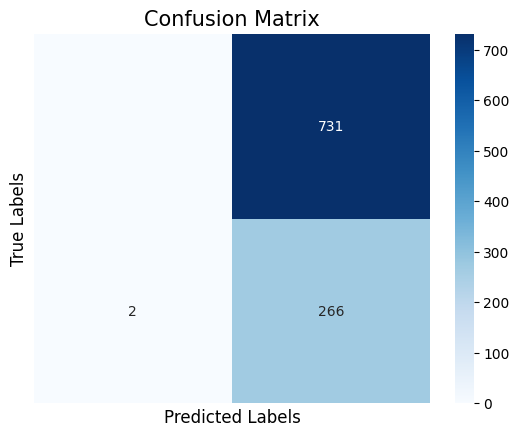

-----------------------------------------------
VAE WEAK GENERATOR-------------------
Latent Dimension = 60, Beta = 30, Validation Method = PLOT, Rows in Training Data = 200000, Batch Size = 1024
Epoch 1, Train Loss: 2.491387, Val Loss: 0.000000
Epoch 2, Train Loss: 0.804133, Val Loss: 0.000000
Epoch 3, Train Loss: 0.704484, Val Loss: 0.000000
Epoch 4, Train Loss: 0.671310, Val Loss: 0.000000
Epoch 5, Train Loss: 0.654664, Val Loss: 0.000000
Epoch 6, Train Loss: 0.646194, Val Loss: 0.000000
Epoch 7, Train Loss: 0.642405, Val Loss: 0.000000
Epoch 8, Train Loss: 0.639558, Val Loss: 0.000000
Epoch 9, Train Loss: 0.637322, Val Loss: 0.000000
Epoch 10, Train Loss: 0.636129, Val Loss: 0.000000
Epoch 11, Train Loss: 0.635163, Val Loss: 0.000000
Epoch 12, Train Loss: 0.634139, Val Loss: 0.000000
Epoch 13, Train Loss: 0.633365, Val Loss: 0.000000
Epoch 14, Train Loss: 0.632917, Val Loss: 0.000000
Epoch 15, Train Loss: 0.632538, Val Loss: 0.000000
Epoch 16, Train Loss: 0.632121, Val Loss: 0.0000

c:\Users\SCHUGD\Desktop\MasterThesis\github_USE_THIS!!\MasterThesis\utils.py:225: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


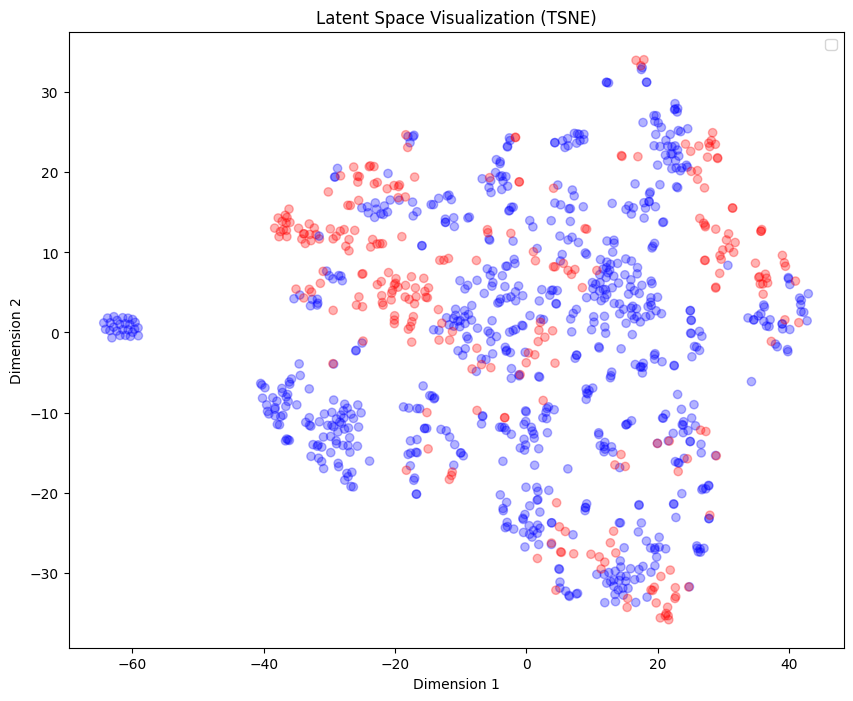

Epoch 51, Train Loss: 0.627448, Val Loss: 0.000000
💽Saved Model at Epoch 51💽
Epoch 52, Train Loss: 0.627423, Val Loss: 0.000000
Epoch 53, Train Loss: 0.627404, Val Loss: 0.000000
Epoch 54, Train Loss: 0.627369, Val Loss: 0.000000
Epoch 55, Train Loss: 0.627355, Val Loss: 0.000000
Epoch 56, Train Loss: 0.627325, Val Loss: 0.000000
Epoch 57, Train Loss: 0.627310, Val Loss: 0.000000
Epoch 58, Train Loss: 0.627286, Val Loss: 0.000000
Epoch 59, Train Loss: 0.627273, Val Loss: 0.000000
Epoch 60, Train Loss: 0.627254, Val Loss: 0.000000
Epoch 61, Train Loss: 0.627242, Val Loss: 0.000000
Epoch 62, Train Loss: 0.627221, Val Loss: 0.000000
Epoch 63, Train Loss: 0.627209, Val Loss: 0.000000
Epoch 64, Train Loss: 0.627196, Val Loss: 0.000000
Epoch 65, Train Loss: 0.627183, Val Loss: 0.000000
Epoch 66, Train Loss: 0.627175, Val Loss: 0.000000
Epoch 67, Train Loss: 0.627165, Val Loss: 0.000000
Epoch 68, Train Loss: 0.627150, Val Loss: 0.000000
Epoch 69, Train Loss: 0.627144, Val Loss: 0.000000
Epoch

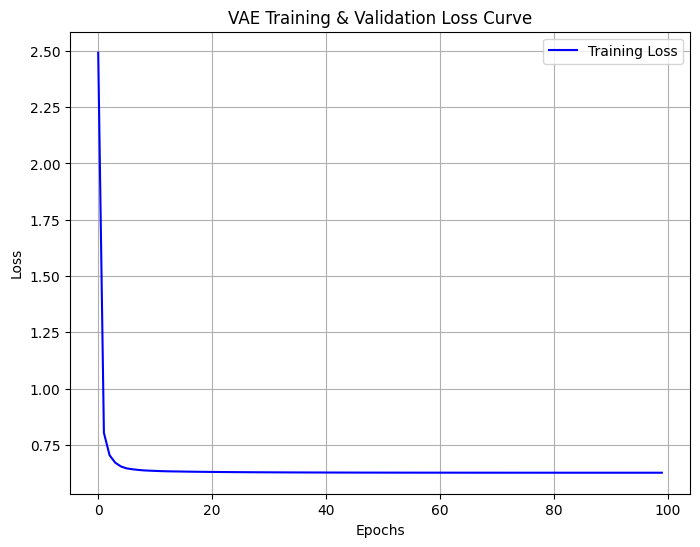

c:\Users\SCHUGD\Desktop\MasterThesis\github_USE_THIS!!\MasterThesis\utils.py:225: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


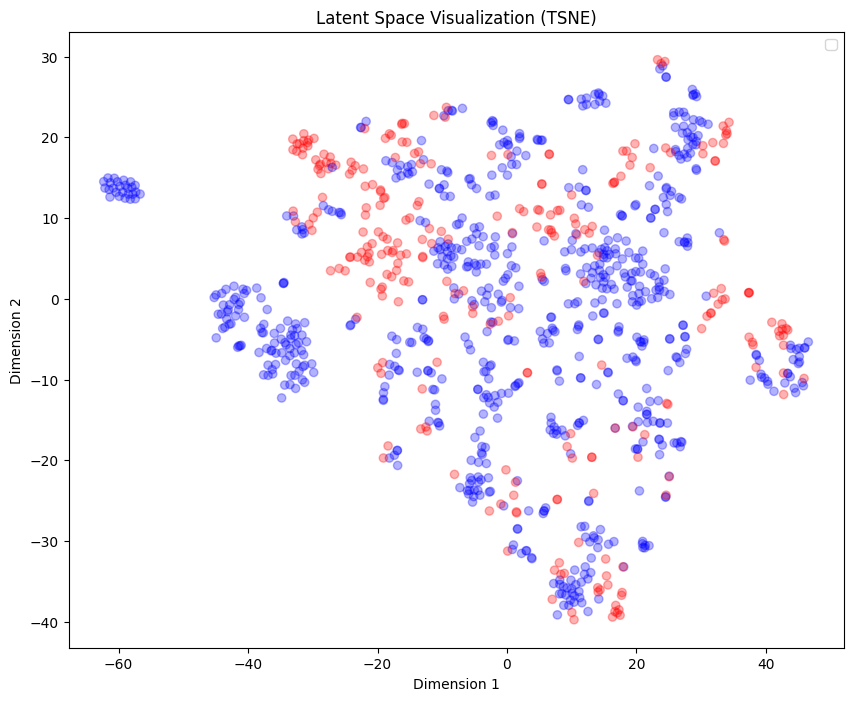

Reconstructed shape:  (10, 1000, 50, 43)
Reconstructed shape:  (1000, 50, 43)
Batch shape:  (1000, 50, 43)
BINARY log_probs shape:  (1000, 50, 29)
CONTINOUS log_probs shape:  (1000, 50, 14)
log_probs shape:  (1000, 50, 43)
mean final reconstruction score shape:  (1000,)
recon error from val 0.6258251667022705
recon error from val 0.621683657169342
recon error from val 0.6109797358512878
recon error from val 0.6211841106414795
recon error from val 0.6416252255439758
recon error from val 0.6153022050857544
recon error from val 0.6104626059532166
recon error from val 0.6268284916877747
recon error from val 0.632160484790802
recon error from val 0.606354296207428
recon error from val 0.6480226516723633
recon error from val 0.6549084186553955
recon error from val 0.6108448505401611
recon error from val 0.6216536164283752
recon error from val 0.6208442449569702
recon error from val 0.6157317161560059
recon error from val 0.6096398830413818
recon error from val 0.6505158543586731
recon error 

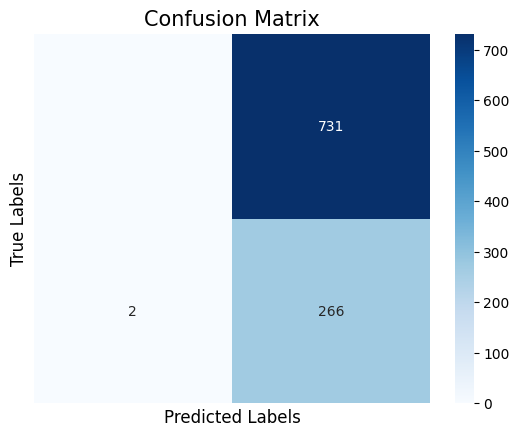

-----------------------------------------------
VAE 2X----------------------
Latent Dimension = 60, Beta = 30, Validation Method = PLOT, Rows in Training Data = 200000, Batch Size = 1024
Epoch 1, Train Loss: 18.435289, Val Loss: 0.000000
Epoch 2, Train Loss: 2.165592, Val Loss: 0.000000
Epoch 3, Train Loss: 1.248394, Val Loss: 0.000000
Epoch 4, Train Loss: 1.067014, Val Loss: 0.000000
Epoch 5, Train Loss: 0.949267, Val Loss: 0.000000
Epoch 6, Train Loss: 0.905044, Val Loss: 0.000000
Epoch 7, Train Loss: 0.871706, Val Loss: 0.000000
Epoch 8, Train Loss: 0.852368, Val Loss: 0.000000
Epoch 9, Train Loss: 0.836685, Val Loss: 0.000000
Epoch 10, Train Loss: 0.825055, Val Loss: 0.000000
Epoch 11, Train Loss: 0.815140, Val Loss: 0.000000
Epoch 12, Train Loss: 0.807527, Val Loss: 0.000000
Epoch 13, Train Loss: 0.800612, Val Loss: 0.000000
Epoch 14, Train Loss: 0.794554, Val Loss: 0.000000
Epoch 15, Train Loss: 0.788810, Val Loss: 0.000000
Epoch 16, Train Loss: 0.783178, Val Loss: 0.000000
Epoch

c:\Users\SCHUGD\Desktop\MasterThesis\github_USE_THIS!!\MasterThesis\utils.py:225: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


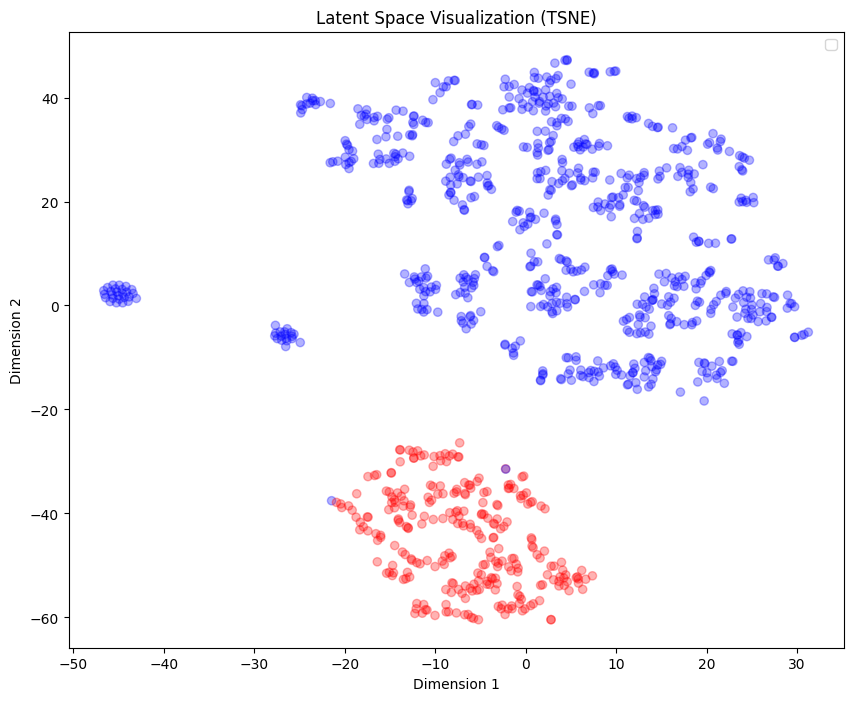

Epoch 51, Train Loss: 0.647239, Val Loss: 0.000000
💽Saved Model at Epoch 51💽
Epoch 52, Train Loss: 0.646679, Val Loss: 0.000000
Epoch 53, Train Loss: 0.646146, Val Loss: 0.000000
Epoch 54, Train Loss: 0.645671, Val Loss: 0.000000
Epoch 55, Train Loss: 0.645256, Val Loss: 0.000000
Epoch 56, Train Loss: 0.644857, Val Loss: 0.000000
Epoch 57, Train Loss: 0.644436, Val Loss: 0.000000
Epoch 58, Train Loss: 0.644141, Val Loss: 0.000000
Epoch 59, Train Loss: 0.643847, Val Loss: 0.000000
Epoch 60, Train Loss: 0.643565, Val Loss: 0.000000
Epoch 61, Train Loss: 0.643319, Val Loss: 0.000000
Epoch 62, Train Loss: 0.643052, Val Loss: 0.000000
Epoch 63, Train Loss: 0.642818, Val Loss: 0.000000
Epoch 64, Train Loss: 0.642600, Val Loss: 0.000000
Epoch 65, Train Loss: 0.642423, Val Loss: 0.000000
Epoch 66, Train Loss: 0.642242, Val Loss: 0.000000
Epoch 67, Train Loss: 0.642076, Val Loss: 0.000000
Epoch 68, Train Loss: 0.641913, Val Loss: 0.000000
Epoch 69, Train Loss: 0.641772, Val Loss: 0.000000
Epoch

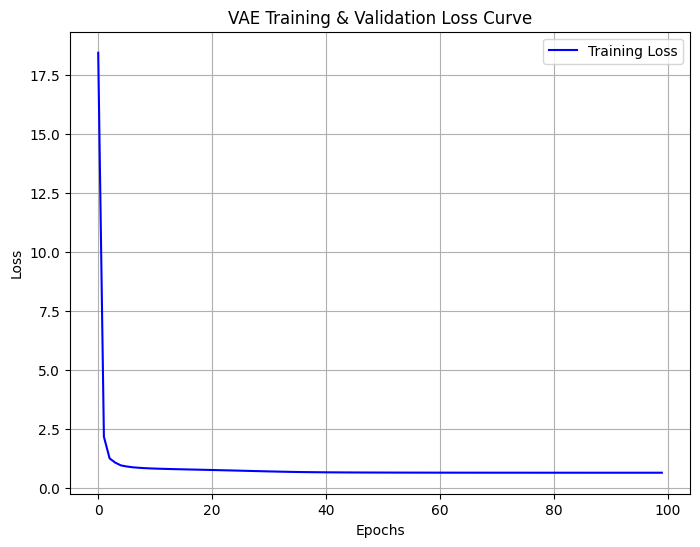

c:\Users\SCHUGD\Desktop\MasterThesis\github_USE_THIS!!\MasterThesis\utils.py:225: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


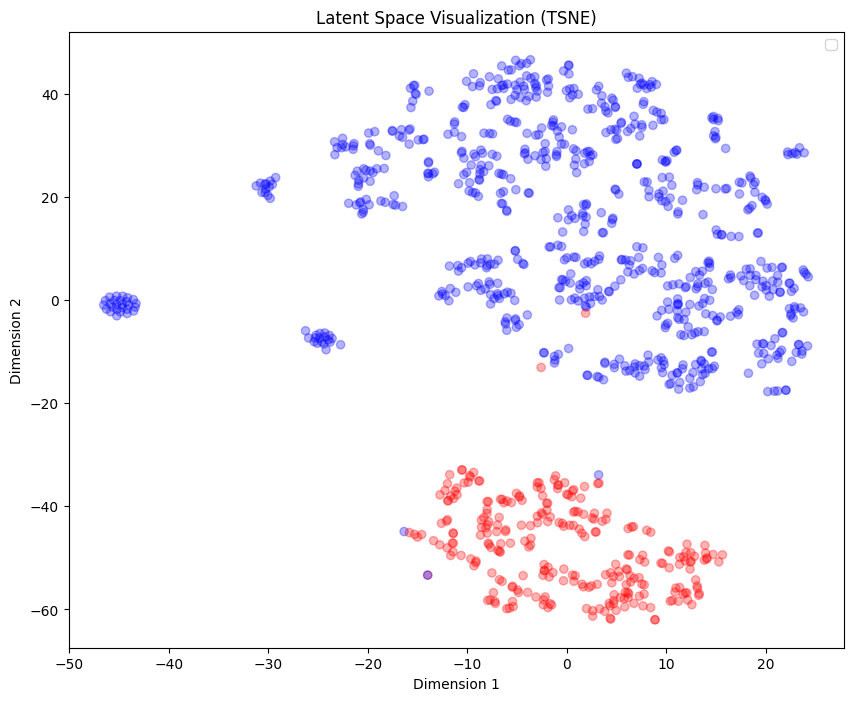

Reconstructed shape:  (10, 1000, 50, 43)
Reconstructed shape:  (1000, 50, 43)
Batch shape:  (1000, 50, 43)
BINARY log_probs shape:  (1000, 50, 29)
CONTINOUS log_probs shape:  (1000, 50, 14)
log_probs shape:  (1000, 50, 43)
mean final reconstruction score shape:  (1000,)
recon error from val 0.6400595903396606
recon error from val 0.6357748508453369
recon error from val 0.6247397065162659
recon error from val 0.6379187703132629
recon error from val 0.6569068431854248
recon error from val 0.6292252540588379
recon error from val 0.626997709274292
recon error from val 0.6427100896835327
recon error from val 0.6457579731941223
recon error from val 0.6215269565582275
recon error from val 0.6620001792907715
recon error from val 0.6515316367149353
recon error from val 0.6272591948509216
recon error from val 0.6397613286972046
recon error from val 0.6371895670890808
recon error from val 0.630665123462677
recon error from val 0.6261919140815735
recon error from val 0.6630476117134094
recon error

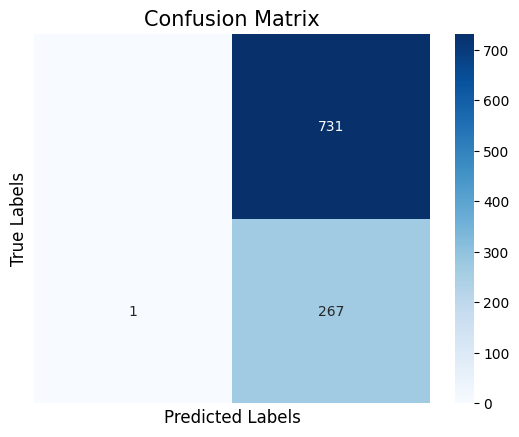

-----------------------------------------------
VAE 2X WEAK GENERATOR------------------
Latent Dimension = 60, Beta = 30, Validation Method = PLOT, Rows in Training Data = 200000, Batch Size = 1024


KeyboardInterrupt: 

In [277]:
reload(utils)
reload(anomaly_detection_functions)
# Regular HYPERPARAMETERS 
input_dim = np.size(processeddataframe['features'][0])
#input_dim = 42
epochs = 100
n_samples = 8
# Best 512 settigns: AdamW with LR=1e-05, WD=1e-06, Beta1=0.85, Beta2=0.98  
learning_rate = 1e-04
weight_decay = 1e-06
# FactorVAE
learning_rate_disc = 5e-5 # increase this
# Annealing and Early stop
steps_anneal = epochs * len(train_dataset)  
alpha = 0.0  # Minimum learning rate as a fraction of the initial learning rate
validation_method = "PLOT" # None, B_VAE, TC, B_TCVAE
patience = 5  

# IMPORTANT 
latent_dim= 2  
beta = 20 # 20
beta_tc = 0 #1.008 # keep in mind this is tuned based on that we get tc loss = -244..

gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0
##################

AD = False

cosine_decay_schedule = CosineDecay(
    1e-03, steps_anneal, alpha=alpha
)

# Hyperparameter search space
latent_dims = [60,50]  # Example values for latent dimension
beta_values = [30,80]

it = 0
reconstruction_AD = True
latent_AD = False
# Iterate over all combinations
for latent_dim, beta in itertools.product(latent_dims, beta_values):
    time = datetime.now().strftime("%H-%M")
    model_name ="BASE_LSTM_VAE"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'

    print(f"Training with: latent_dim={latent_dim}, beta={beta} validation_method={validation_method}")

    vae = VAE_multiplesamples(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    vae_weakGen = VAE_weakGenerator(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    vae_2x = VAE_2x(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    VAE_2x_weakGen = VAE_2x_weak_generator(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)

    #optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay, beta_1=beta1, beta_2=beta2)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    optimizer_weakGen = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    optimizer_2x = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    optimizer_2x_weakGen = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)

    print("VAE--------------")
    train_losses, val_losses, real_epochs, time, show_val, model_path, vae = train_model(vae,optimizer,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)


    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)

    reconstruction_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD)
    results, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
    reconstruction_accuracy , latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,reconstruction_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)
    print("-----------------------------------------------")

    del vae, optimizer
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')
    
    print("VAE WEAK GENERATOR-------------------")
    time = datetime.now().strftime("%H-%M")
    model_name ="LSTM_VAE_WEAKGEN"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
    train_losses, val_losses, real_epochs, time, show_val, model_path, vae_weakGen = train_model(vae_weakGen,optimizer_weakGen,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)

    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(vae_weakGen, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)

    reconstruction_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD)
    results, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
    reconstruction_accuracy , latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,reconstruction_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)
    print("-----------------------------------------------")
    
    del vae_weakGen, optimizer_weakGen
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')
    
    print("VAE 2X----------------------")
    time = datetime.now().strftime("%H-%M")
    model_name ="LSTM_VAE_2x"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
    train_losses, val_losses, real_epochs, time, show_val, model_path, vae_2x = train_model(vae_2x,optimizer_2x,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)

    
    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(vae_2x, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)

    reconstruction_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD)
    results, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
    reconstruction_accuracy , latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,reconstruction_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)
    print("-----------------------------------------------")

    del vae_2x, optimizer_2x
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')
    
    print("VAE 2X WEAK GENERATOR------------------")
    time = datetime.now().strftime("%H-%M")
    model_name ="LSTM_VAE_2x_WEAKGEN"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
    train_losses, val_losses, real_epochs, time, show_val, model_path, VAE_2x_weakGen = train_model(VAE_2x_weakGen,optimizer_2x_weakGen,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)

   
    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(VAE_2x_weakGen, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type='TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)

    reconstruction_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD)
    results, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
    reconstruction_accuracy , latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,reconstruction_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)
    print("-----------------------------------------------")

    del VAE_2x_weakGen, optimizer_2x_weakGen
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')


**Iterative Training on Saved Model**

In [ ]:
# Regular HYPERPARAMETERS 
#input_dim = np.size(processeddataframe['features'][0])
input_dim = 42
epochs = 50
n_samples = 1
# Best 512 settigns: AdamW with LR=1e-05, WD=1e-06, Beta1=0.85, Beta2=0.98  
learning_rate = 1e-04
weight_decay = 1e-06
# FactorVAE
learning_rate_disc = 5e-5
# Annealing and Early stop
steps_anneal = epochs * len(train_dataset)  
alpha = 0.0  # Minimum learning rate as a fraction of the initial learning rate
validation_method = "PLOT" # None, B_VAE, TC, B_TCVAE, PLOT
patience = 5  

# IMPORTANT 
latent_dim= 30  
beta = 0 # 20
beta_tc = 1.008 #1.008 # keep in mind this is tuned based on that we get tc loss = -244..

gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0
##################

AD = False

time = datetime.now().strftime("%H-%M")
model_name ="BEST_VAE"
new_model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/Iter_BEST_{model_name}_{time}.keras'

cosine_decay_schedule = CosineDecay(
    1e-03, steps_anneal, alpha=alpha
)


vae = keras.models.load_model(best_model_path)

#optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay, beta_1=beta1, beta_2=beta2)
#optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=weight_decay)
optimizer = vae.optimizer
discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)

train_losses, val_losses, real_epochs, time, show_val, model_path, vae = train_model(vae,optimizer,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path = new_model_path)


plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time, show_val= show_val)
#analyze_latent_variance(vae,train_dataset, test_dataset)
#analyze_kl_divergence(vae, train_dataset, test_dataset)
#get_latent_representations_label(vae, test_dataset,latent_dim, beta,n_critic,gamma,time, 'PCA', save = False)
get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,'TSNE', save = True)
#get_latent_representations_label(vae, train_dataset, 'TSNE')

if AD:
  reconstruction_AD = False
  latent_AD = True
  reconstruction_threshold, latent_threshold, mean_train, variance_train = get_threshold_from_train(model_path, reconstruction_AD, latent_AD)
  results, distances = anomaly_detection(vae, reconstruction_AD, latent_AD, mean_train, variance_train)
  reconstruction_accuracy , latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,reconstruction_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time)

**Test Saved Model**

Latent Dimension = 38, Beta = 30, Gamma = 0, N_critic = 0, Beta_TC = 0, Validation Method = PLOT, Rows in Training Data = 100000, Batch Size = 1024


c:\Users\SCHUGD\Desktop\MasterThesis\github_USE_THIS!!\MasterThesis\utils.py:225: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


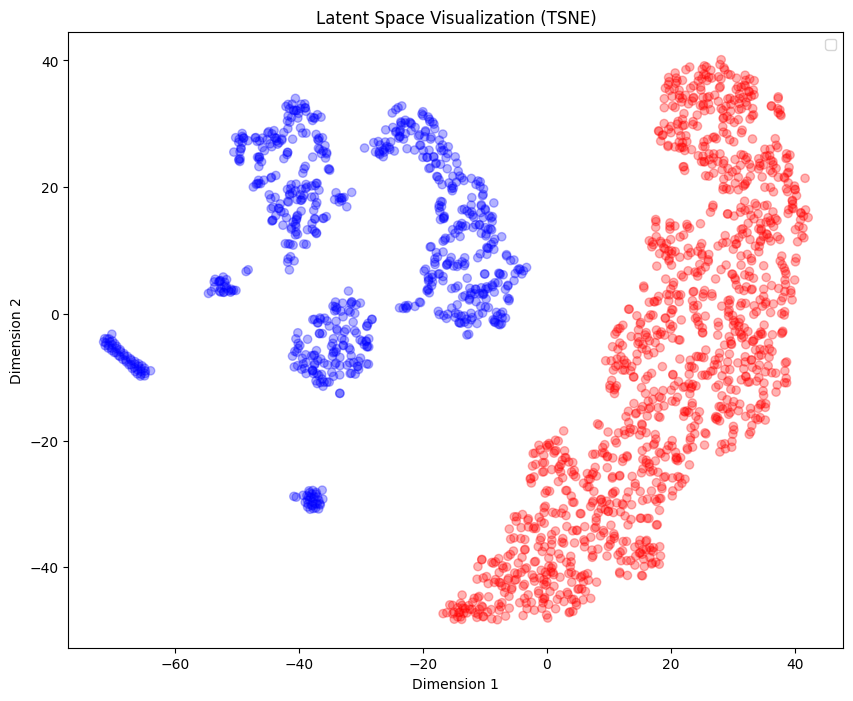

In [57]:
best_model_path = "./Resources/Models/BetaVAE_EPOCHS38_LD30_BETA50_NT80000_BATCH512_INPUT24_17-14.keras"
load_vae = keras.models.load_model(best_model_path)
load_vae.trainable = False  # Freeze model weights
get_latent_representations_label(load_vae, test_dataset, 0, 0 ,0,0,0,epoch = 0,name = "-",type='TSNE', save = False, AWS = AWS, s3 = s3, BUCKET = BUCKET)

Collect Mean & Variance from Train completed in 2.8083 seconds
Ball Tree completed in 0.3578 seconds
########### Latent Thhresholds ##############
Normal LATENT threshold: 0.0001312
########################################
Get Thresold from Train completed in 12.7149 seconds
Normal Latent  0.0018291867
Normal Latent  0.0019246594
Normal Latent  0.0021052323
Normal Latent  0.002146561
Normal Latent  0.0025858628
Normal Latent  0.0023375726
Normal Latent  0.002144584
Normal Latent  0.0022777729
Normal Latent  0.0021336202
Normal Latent  0.002221049
Normal Latent  0.0019385787
Normal Latent  0.00197077
Normal Latent  0.0022751146
Normal Latent  0.002305615
Normal Latent  0.0022022177
Normal Latent  0.00210426
Normal Latent  0.002160423
Normal Latent  0.0022251727
Normal Latent  0.002054479
Normal Latent  0.0020732705
Normal Latent  0.0019979146
Normal Latent  0.0020196259
Normal Latent  0.002331669
Normal Latent  0.0019160447
Normal Latent  0.002169068
Normal Latent  0.0018780008
Normal L

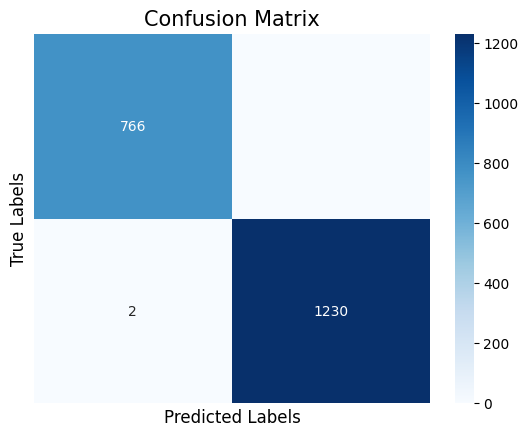

######### ############################ ############


In [65]:
model_path = "./Resources/Models/BetaVAE_EPOCHS38_LD30_BETA50_NT80000_BATCH512_INPUT24_17-14.keras"
model_name = "EmbeddingBetaVAE"
#model_path = best_model_path
reconstruction_AD = False
latent_AD = True
n_rows_train = 80000
reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD)
results, results_probs, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)

In [53]:
model_path = "./Resources/Models/BetaVAE_EPOCHS38_LD30_BETA50_NT80000_BATCH512_INPUT24_17-14.keras"

mean_train, variance_train = get_mean_variances(model_path,train_dataset,test = False)
mixed_means, mixed_variances, mixed_labels = get_mean_variances(model_path, test_dataset)
mixed2_means, mixed2_variances, mixed2_labels = get_mean_variances(model_path, test_threshold_dataset)

Get Mean and Variances completed in: 2.8131 seconds
Get Mean and Variances completed in: 2.1169 seconds
Get Mean and Variances completed in: 0.9772 seconds


In [ ]:
mixed_means = mixed_means[:5000]
mixed_variances = mixed_variances[:5000]
mixed_labels = mixed_labels[:5000]

print(len(mean_train))
print(sum(mixed_labels), len(mixed_labels) - sum(mixed_labels))
print(sum(mixed2_labels), len(mixed2_labels) - sum(mixed2_labels))

Isolation Forest training completed in 17.3649 seconds
----Isolation Forest AD----
Anomali Detection using Isolation Forest completed in : 2.0567 seconds
Detected 1258 anomalies out of 1998 samples
Anomaly percentage: 62.96%
######################
Computing t-SNE embedding...


c:\Users\SCHUGD\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


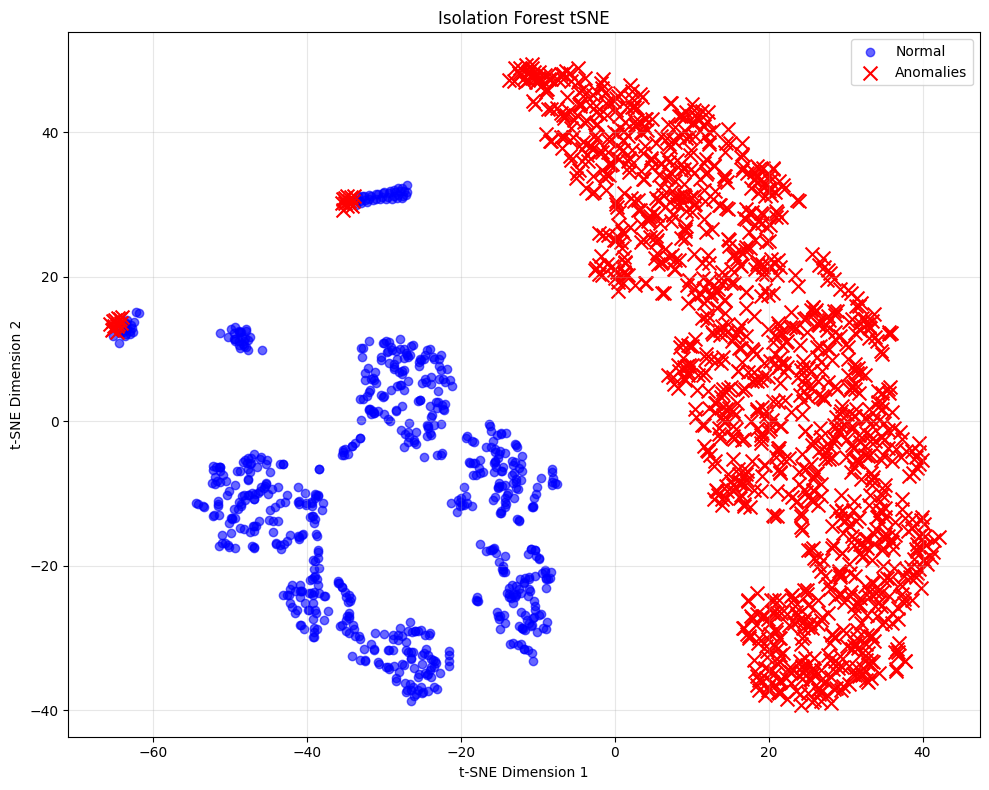

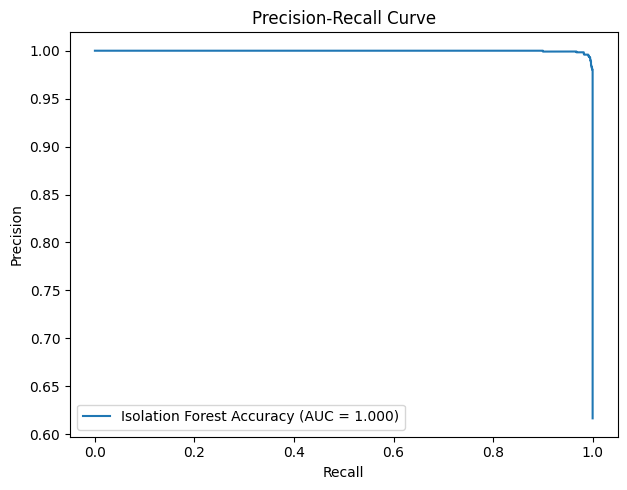

Isolation Forest Accuracy Precision: [0.61661662 0.61692539 0.61723447 ... 1.         1.         1.        ]
Isolation Forest Accuracy Recall: [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.62337662e-03
 8.11688312e-04 0.00000000e+00]
Isolation Forest Accuracy PR AUC: 0.9998


In [60]:
#print(np.array(mean_train).min())
scaled_features, scaler = prepare_features(np.array(mean_train), np.array(variance_train))
mixed_scaled_features, mixed_scaler = prepare_features(np.array(mixed_means), np.array(mixed_variances))

iso_model = train_isolation_forest(scaled_features, contamination=0.005, n_estimators=10000, random_state=42)
#svm_model = train_one_class_svm(scaled_features, nu=0.00001, kernel='rbf', gamma='scale')
#hdbscan_model = train_hdbscan_detector(scaled_features,min_cluster_size=500,min_samples=500, metric='cosine')


iso_anomaly_mask, iso_anomaly_scores = detect_anomalies_isolation_forest(iso_model, mixed_scaled_features)
#svm_anomaly_mask, svm_anomaly_scores = detect_anomalies_one_class_svm(svm_model, mixed_scaled_features)
#hdbscan_outliers, test_labels, strengths = detect_anomalies_hdbscan(hdbscan_model , mixed_scaled_features)

iso_pca = visualize_anomalies(mixed_scaled_features, iso_anomaly_mask, "Isolation Forest tSNE")
#svm_pca = visualize_anomalies(mixed_scaled_features, svm_anomaly_mask, "SVM TSNE")

#hdbscan_pca = visualize_anomalies(mixed_scaled_features, hdbscan_outliers,"HDBSCAN TSNE")
#visualize_results(scaled_features, mixed_scaled_features, hdbscan_outliers)

evaluate_anomaly_detector(iso_anomaly_scores, mixed_labels, "Isolation Forest Accuracy")
#evaluate_anomaly_detector(svm_anomaly_scores, mixed_labels, "SVM Accuracy")
#evaluate_anomaly_detector(hdbscan_outliers, mixed_labels, "HDBSCAN Accuracy")

#evaluation = evaluate_hdbscan_detector(mixed_labels, anomaly_mask)


